## Getting started

- Run first cell with either `load_hamburg_netatmo_data()` or `load_stuttgart_sensor_community_data()` and assign qc_gdf, m5_gdf, rest_gdf. m5 means m5 level of QC. this could also be adapted to only check up to the m4 level
(make sure to use the correct crs for plotting, idk why they are not the same)
- if you need to create the 50 neighbour testsets for each sensor, run the Dataset Creation for ML cell. You can also adjust the nearest neighbour count. The created dataset has the first column the target variable of the sensor itself by sensor id and timestamp, then the neighbour columns and then afterwards feature columns. Currently the time is the only feature (with a really small influence, like 0.03 on the final result) (depending on the amount of sensors and number of neighbours can take over 180 min per provider)
- after creating the testsets, run the ML Model Eval to create a eval_df that includes the information about each model, that can be plotted afterwards. This step can take very long, e.g. over 240 min, so make sure to save the eval_df to csv to load it instantly and make sure to not override an existing eval_df accidentally
- profit

# Helper methods - run first

In [142]:
from scipy.spatial import KDTree
import pandas as pd
import geopandas as gpd
from pytz import UTC
import numpy as np

start = pd.Timestamp('2023-06-01 00:30:00', tz=UTC)
end = start + pd.Timedelta(days=30)

def create_neighbour_df(tree, coords, nn_count, p_ids_df, parent_gdf):
    # Get nearest neighbors including current location, euclidean distance
    dist, idx = tree.query(coords, k=nn_count + 1, p=2)

    # First entry is the point itself
    idx = idx[0]
    dist = dist[0]

    # Drop Timestamp and geometry
    gdB_nearest = p_ids_df.iloc[idx]
    neighbours_gdf = parent_gdf[parent_gdf['p_id'].isin(gdB_nearest['p_id'])]

    return neighbours_gdf

def create_dataset_for_sensor_id(start, end, neighbours_gdf, sensor_id, freq, provider, nn_count, feature_count, path, min_values=10):
    columns = ['y']
    columns.extend(['ta_' + str(i) for i in range(1, nn_count + 1)])
    columns.extend(['feature_' + str(i) for i in range(1, feature_count + 1)])
    
    X = pd.DataFrame(columns=columns)
    X.reset_index(drop=True, inplace=True)

    for date in pd.date_range(start=start, end=end, freq=f'{freq}min'):
        start_time = date.to_datetime64()
        end_time = start_time + pd.Timedelta(minutes=freq)

        neighbour_ids = neighbours_gdf['p_id']
        filtered_gdf = neighbours_gdf.copy()
        filtered_gdf = filtered_gdf[(filtered_gdf['time'] >= start_time) & (filtered_gdf['time'] < end_time)]
        filtered_gdf.set_index('p_id', inplace=True)

        if filtered_gdf.empty:
            continue

        # Convert time to time of day
        filtered_gdf['time'] = filtered_gdf['time'].apply(lambda x: (x.hour * 60 + x.minute) * 2 * np.pi / (24 * 60))
        filtered_gdf.rename(columns={'time': 'time_angle'}, inplace=True)

        # Calculate continuous representation of time as an angle in radians
        filtered_gdf['sin_time'] = np.sin(filtered_gdf['time_angle'])
        filtered_gdf['cos_time'] = np.cos(filtered_gdf['time_angle'])

        nr_cols = nn_count + feature_count + 1
        x = np.empty(nr_cols, dtype=object)
        x[:] = np.nan

        for index, neighbour in neighbour_ids.items():
            if neighbour_ids[index] in filtered_gdf.index:
                x[index] = filtered_gdf.loc[neighbour_ids[index]].ta

        # Skip if the target value is missing
        if x[0] is np.nan:
            continue
    
        # Set time feature as last column
        x[-1] = filtered_gdf['sin_time'].values[0]
        x = x.reshape(1, nr_cols)

        new = pd.DataFrame(x, columns=columns)
    
        X = pd.concat([X, new], axis=0, ignore_index=True)

    if X.empty or len(X.values) < min_values:
        print(f'No data for sensor {sensor_id} with {len(X.values)} entries')
        return

    X.to_csv(f'./data/testsets/{path}/{provider}/{sensor_id}_dataset.csv', index=False)
    return X

# Station interpolation

Use-Case: Moving sensors -> simulate bus stop with different intervals and rest durations

Select one station that and set time interval. Interpolate missing values by regressor with training from surrounding stations.

In [75]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, box
from matplotlib.lines import Line2D

crs_hamburg = 'EPSG:3857'
crs_stuttgart = 'EPSG:4326'

def load_hamburg_netatmo_data():
    df = pd.read_csv('./data/netatmo/june_hamburg/hamburg_06_23_after_qc.csv', parse_dates=['time'])

    df.drop('z', axis=1, inplace=True)

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[1], row[0]), axis=1), crs=crs_stuttgart)

    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

def load_stuttgart_sensor_community_data():
    crs = 'EPSG:4326'
    df = pd.read_csv('./data/sensor.community/2023-06_all_qc_after.csv', parse_dates=['time'])

    df.drop('z', axis=1, inplace=True)

    # Stuttgart bounding box
    lat1, lon1 = 48.9519, 8.8402
    lat2, lon2 = 48.4698, 9.5348

    # # Create a bounding box geometry
    bounding_box = box(lon1, lat1, lon2, lat2)

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs)
    
    qc_gdf = qc_gdf[qc_gdf.geometry.within(bounding_box)]

    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

# qc_gdf, m5_gdf, rest_gdf = load_stuttgart_sensor_community_data()
qc_gdf, parent_gdf, rest_gdf = load_hamburg_netatmo_data()

p_ids_df = qc_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

print(len(locations))

713


## Plotting QC

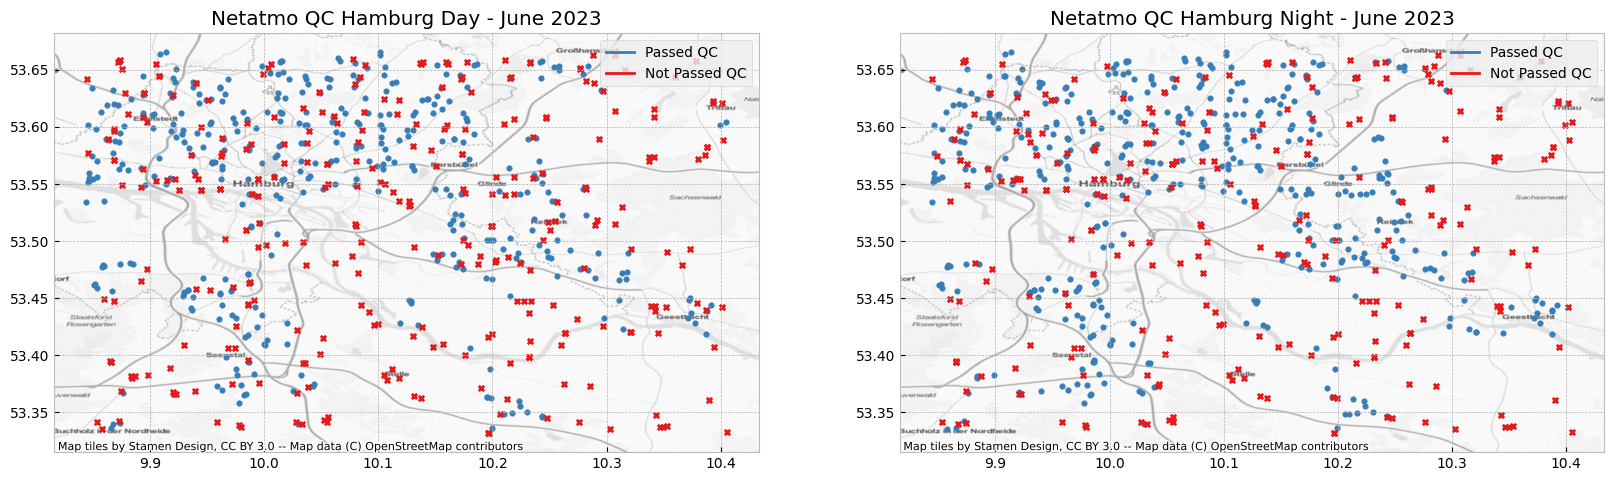

In [93]:
def plot_qc_locations(gdf1, gdf2, title, ax, crs):
    gdf1.plot(marker='o', ax=ax, markersize=15, color='#377eb8')
    gdf2.plot(marker='x', ax=ax, markersize=15, color='#e41a1c' )

    custom_lines = [Line2D([0], [0], color='#377eb8', lw=2),
                    Line2D([0], [0], color='#e41a1c', lw=2)]

    ax.legend(handles=custom_lines, labels=['Passed QC', 'Not Passed QC'], loc='upper right')

    # Set axis title and add basemap
    ax.set_title(title)
    ctx.add_basemap(
        ax,
        crs=crs,
        alpha=0.7,
        source=ctx.providers.Stamen.TonerLite
    )

def plot_qc_locations_for_city(city, provider, crs):

    # Plot gdf
    fig, ax = plt.subplots(1, 2, figsize=(20,15))

    # Filter by time because first time everything is false
    m5_gdf_day = parent_gdf[parent_gdf['time'] == '2023-06-19 14:00:00']
    rest_gdf_day = rest_gdf[rest_gdf['time'] == '2023-06-19 14:00:00']

    plot_qc_locations(m5_gdf_day, rest_gdf_day, f'{provider} QC {city} Day - June 2023', ax[0], crs)

    m5_gdf_night = parent_gdf[parent_gdf['time'] == '2023-06-19 02:00:00']
    rest_gdf_night = rest_gdf[rest_gdf['time'] == '2023-06-19 02:00:00']

    plot_qc_locations(m5_gdf_night, rest_gdf_night, f'{provider} QC {city} Night - June 2023', ax[1], crs)

# plot_qc_locations_for_city('Stuttgart', 'Sensor.Community', crs_stuttgart)
plot_qc_locations_for_city('Hamburg', 'Netatmo', crs_stuttgart)

## Find Sensor Ids by Locations

### Sensor Locations Hamburg

In [ ]:
Nienstedten = [53.552792,9.846225]
Stellingen = [53.593895,9.928416]
Fuhlsbüttel = [53.629954,10.012461]
Eimsbüttel = [53.569332,9.956562]
Eppendorf = [53.582269,9.986992]
Hafencity = [53.541312,9.988897]
Mümmelmansberg = [53.518018,10.165679]
WinsenLuhe = [53.348226,10.209836]
Emmelndorf = [53.393568,9.985493]
Harburg = [53.457814,9.971818]

names = ['Nienstedten', 'Stellingen', 'Fuhlsbüttel', 'Eimsbüttel', 'Eppendorf', 'Hafencity', 'Mümmelmansberg', 'WinsenLuhe', 'Emmelndorf', 'Harburg']
stations = pd.DataFrame([Nienstedten, Stellingen, Fuhlsbüttel, Eimsbüttel, Eppendorf, Hafencity, Mümmelmansberg, WinsenLuhe, Emmelndorf, Harburg])
number_of_neighbours_per_station = 1

In [132]:
Eimsbüttel = [53.56933, 9.95654]

names = ['Eimsbüttel']
stations = pd.DataFrame([Eimsbüttel])
number_of_neighbours_per_station = 201

     distance               p_id                  geometry
444  0.000157  70:ee:50:3f:2e:2a  POINT (9.95654 53.56933)
15   0.251641  70:ee:50:00:d3:96  POINT (9.95431 53.56893)
188  0.272719  70:ee:50:16:24:42  POINT (9.95416 53.56872)
283  0.809167  70:ee:50:27:2e:4a  POINT (9.96271 53.56545)
33   0.831899  70:ee:50:01:3d:a0  POINT (9.96209 53.57437)
575  1.027646  70:ee:50:74:33:86  POINT (9.96349 53.56321)
380  1.110883  70:ee:50:32:b6:d2  POINT (9.96274 53.57718)
156  1.495697  70:ee:50:12:f6:cc  POINT (9.96509 53.57975)
208  1.740461  70:ee:50:17:94:9a  POINT (9.96200 53.55463)
467  1.847596  70:ee:50:58:6a:66  POINT (9.94662 53.58270)


/Users/ian/Repos/uni/sensor-data-ml/venv/lib/python3.8/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


KeyError: 'time'

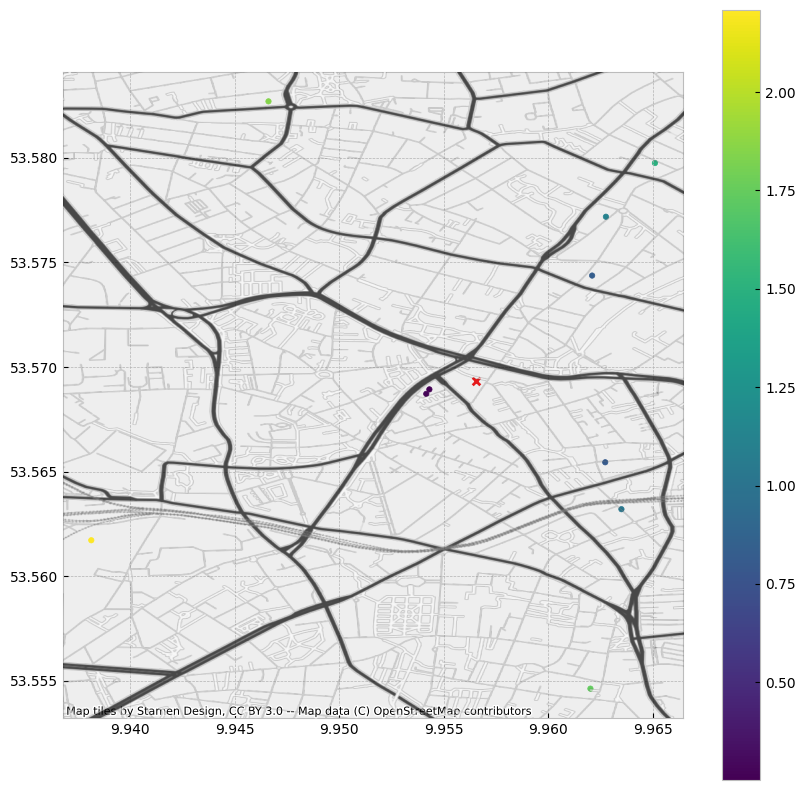

In [143]:
from scipy.spatial import KDTree
from geopandas.tools import sjoin, sjoin_nearest

# set print options
np.set_printoptions(linewidth=110)
pd.set_option('display.width', 200)
plt.style.use('bmh')  # better for plotting geometries vs general plots.
# Select stations

crs = 4326

# Flatten list of x y coordinates
test_locations_gdf = gpd.GeoDataFrame(names, geometry=stations.iloc[:,:].apply(lambda row: Point(row[1], row[0]), axis=1), crs=crs)

p_ids_df = qc_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

# More build time but better query time
tree = KDTree(locations, balanced_tree=True)
neighbours = []

for index, row in test_locations_gdf.iterrows():
    coords = row.geometry.coords
    dist, idx = tree.query(coords, k=number_of_neighbours_per_station, p=2)

    idx = idx[0]
    # Multiply each distance by 111 to get km
    dist = dist[0] * 111
    neighbours.append(pd.DataFrame(zip(idx, dist), columns=["index", "distance"]))

neighbours_df = pd.concat(neighbours, axis=1)
neighbours_df.set_index("index", inplace=True)

gdB_nearest = neighbours_df.join(p_ids_df, how="inner")
gdB_nearest.sort_values(by=['distance'], inplace=True)

print(gdB_nearest.head(10))

# gdB_nearest = p_ids_df.iloc[neighbour_indexes]
neighbour_ids = gdB_nearest['p_id']

gdf_nearest = gpd.GeoDataFrame(gdB_nearest, geometry=gdB_nearest['geometry'], crs=crs)

combined = sjoin_nearest(gdf_nearest, test_locations_gdf, how='left')

def plot_neighbours_min_distance(crs, test_locations_gdf, gdf_nearest, nr_neighbours, min_distance=0.0):
    fig, ax = plt.subplots(figsize=(10,10))

    min_distance_gdf = gdf_nearest[gdf_nearest['distance'] > min_distance]

    min_distance_gdf.iloc[1:nr_neighbours + 1].plot(marker='o', ax=ax, markersize=15, column='distance', legend=True)
    test_locations_gdf.plot(marker='x', ax=ax, markersize=30, color='#e41a1c')
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

    # zoom = ctx.tile._calculate_zoom(*gdf_nearest.total_bounds)
    ctx.add_basemap(
        ax,
        crs=crs,
        alpha=0.7,
        source=ctx.providers.Stamen.TonerLines
    )

for min_distance in [0, 0.5, 1]: # 2, 5, 10
    min_distance_gdf = gdf_nearest[gdf_nearest['distance'] > min_distance]
    plot_neighbours_min_distance(crs, gdf_nearest.iloc[0:1], min_distance_gdf, 10, 0)
    test_df = create_dataset_for_sensor_id(start, end, min_distance_gdf, '70:ee:50:3f:2e:2a', 30, 'netatmo', 10, 1, 'min_distance', 10)

In [ ]:
'70:ee:50:3f:2e:2a'

### Other stuff dataset related

Text(0.5, 0, 'Date')

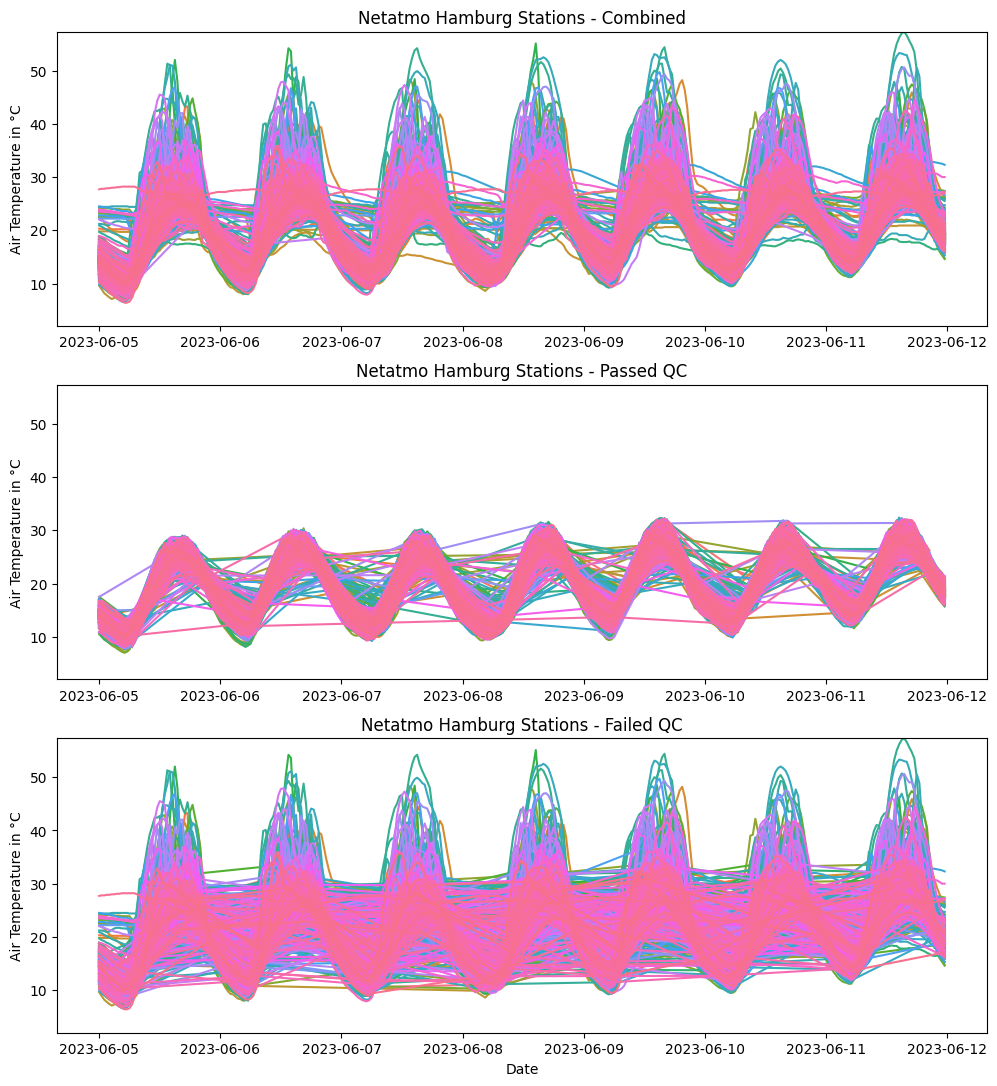

In [98]:
import seaborn as sns
import matplotlib.dates as md

# Plot lines of temperature of stations

# Plot daily_mean_temp_2m as line plot
fig, ax = plt.subplots(3, 1, figsize=(12, 13))
ymin, ymax = qc_gdf.ta.min(), qc_gdf.ta.max()

def plot_stations_ta(gdf, ax, title):
    grouped_df = gdf.groupby([pd.Grouper(key='p_id'), pd.Grouper(key="time", freq="10T")]).agg({'ta': 'first'})

    sns.lineplot(x='time', 
             y='ta',
             hue='p_id', 
             data=grouped_df,
             ax=ax,
             legend=False)
    ax.set_ylabel('Air Temperature in °C')
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(None)
    ax.set_title(title)

plot_stations_ta(qc_gdf[(qc_gdf['time'] >= '2023-06-05') & (qc_gdf['time'] < '2023-06-12')], ax[0], 'Netatmo Hamburg Stations - Combined')
plot_stations_ta(parent_gdf[(parent_gdf['time'] >= '2023-06-05') & (parent_gdf['time'] < '2023-06-12')], ax[1], 'Netatmo Hamburg Stations - Passed QC')
plot_stations_ta(rest_gdf[(rest_gdf['time'] >= '2023-06-05') & (rest_gdf['time'] < '2023-06-12')], ax[2], 'Netatmo Hamburg Stations - Failed QC')

ax[2].set_xlabel('Date')

## Dataset Creation For ML

### Script

In [138]:
nn_count = 50
feature_count = 1
stuttgart_interval = 10
netatmo_interval = 30

p_ids_df = qc_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

print('Building tree...')
# More build time but better query time
tree = KDTree(locations, balanced_tree=True)



p_ids_df.reset_index(drop=True, inplace=True)

for index, row in p_ids_df.iterrows():
    print(index)
    coords = row.geometry.coords
    neighbours_gdf, neighbour_ids = create_neighbour_df(coords)

    create_dataset_for_sensor_id(start, end, columns, neighbours_gdf, neighbour_ids, row.p_id, stuttgart_interval, 'sensor.community')


Building tree...
0
No data for sensor 108 with 0 entries
1
2
3
4
5
No data for sensor 212 with 0 entries
6
7
No data for sensor 254 with 0 entries
8
9
10
11
12
No data for sensor 364 with 0 entries
13
No data for sensor 418 with 0 entries
14
15
16
No data for sensor 431 with 0 entries
17
No data for sensor 435 with 0 entries
18
19
No data for sensor 480 with 0 entries
20
No data for sensor 498 with 0 entries
21
22
23
No data for sensor 530 with 0 entries
24
No data for sensor 550 with 0 entries
25
26
27
28
29
30
No data for sensor 674 with 0 entries
31
32
33
34
35
36
No data for sensor 736 with 0 entries
37
No data for sensor 752 with 0 entries
38
No data for sensor 758 with 0 entries
39
No data for sensor 770 with 0 entries
40
41
42
No data for sensor 796 with 0 entries
43
44
45
46
No data for sensor 843 with 0 entries
47
48
49
50
No data for sensor 1205 with 0 entries
51
52
No data for sensor 1329 with 0 entries
53
54
No data for sensor 1347 with 0 entries
55
No data for sensor 1367 

# ML Model Eval

In [39]:
# Create test dataset
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
import os

# Ignore divide by NaN warnings for normalisation
np.seterr(divide='ignore', invalid='ignore')

provider = 'netatmo'
feature_count = 1
results = []

# Test for different number of nearest neighbours
def evaluate_regressor(sensor_id, nr_neighbours, y_test, y_pred, regressor_type, is_imputed):
    return pd.DataFrame({
            "p_id": sensor_id,
            "n_neighbours": nr_neighbours,
            "n_features": feature_count,
            "regressor_type": regressor_type,
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R2": r2_score(y_test, y_pred),
            "is_imputed": is_imputed,
            "provider": provider
            }, index=[0])

for index, row in p_ids_df.iterrows():
    sensor_id = row.p_id

    print(f'Processing {sensor_id}')

    file_path = f'./data/testsets/{provider}/{sensor_id}_dataset.csv'
    if not os.path.isfile(file_path):
        print(f'File {file_path} does not exist')
        continue

    parent_df = pd.read_csv(file_path)
    parent_df.dropna(subset=['y'], inplace=True)

    parent_df_imput = parent_df.copy()

    for index, row in parent_df_imput.iterrows():
        if row.isnull().values.all():
            row.drop(inplace=True)
        row.fillna(row.mean(), inplace=True)

    nr_columns = len(parent_df.columns) - 1 # remove index column

    for nr_neighbours in range(2, 33, 5):
        y = parent_df.iloc[:, 0].values
        features = parent_df.iloc[:, nr_columns:nr_columns-feature_count:-1] # Select features from the end
        neighbours = parent_df.iloc[:, 1:nr_neighbours + 1]

        y_imput = parent_df_imput.iloc[:, 0].values
        features_imput = parent_df_imput.iloc[:, nr_columns:nr_columns-feature_count:-1] # Select features from the end
        neighbours_imput = parent_df_imput.iloc[:, 1:nr_neighbours + 1]

        # Select number of neighbours
        X = pd.concat([neighbours, features], axis=1)
        X_imput = pd.concat([neighbours_imput, features_imput], axis=1)

        if X.empty or X_imput.empty:
            print(f'Empty dataset for {sensor_id} and neighbour count {nr_neighbours}')
            continue

        if len(X.values) < 5 or len(X_imput.values) < 5:
            print(f'Not enough data for {sensor_id} and neighbour count {nr_neighbours} with {len(X.values)} rows')
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1, shuffle=True)

        X_train_imput, X_test_imput, y_train_imput, y_test_imput = train_test_split(
            X_imput, y_imput, test_size=0.3, random_state=1, shuffle=True)
        
        scaler_X = StandardScaler().fit(X_train)
        X_train_norm = scaler_X.transform(X_train)
        X_test_norm = scaler_X.transform(X_test)

        scaler_X_imput = StandardScaler().fit(X_train_imput)
        X_train_imput_norm = scaler_X_imput.transform(X_train_imput)
        X_test_imput_norm = scaler_X_imput.transform(X_test_imput)

        # Run regression for imputed df
        for regr in [("LinearRegressor", LinearRegression()), ("KNN", KNeighborsRegressor(n_neighbors=5, weights='distance')), ("RandomForest", RandomForestRegressor(n_estimators=200, random_state=42)), ("SVMRegressor", SVR(kernel='rbf', gamma='auto')), ("HistGradientBoostingRegressor", HistGradientBoostingRegressor(max_iter=200, random_state=42))]:
            regr_name = regr[0]
            regr = regr[1]

            print(f'Running {regr_name} for {sensor_id} and neighbour count {nr_neighbours}')

            y_pred = None

            regr.fit(X_train_imput_norm, y_train)
            y_pred = regr.predict(X_test_imput_norm)

            results.append(evaluate_regressor(sensor_id, nr_neighbours, y_test, y_pred, regr_name, True))
        
        # Run regression without imputed df
        for regr in [("HistGradientBoostingRegressor", HistGradientBoostingRegressor(max_iter=200, random_state=42))]:
            regr_name = regr[0]
            regr = regr[1]

            y_pred = None

            regr.fit(X_train_norm, y_train)
            y_pred = regr.predict(X_test_norm)

            results.append(evaluate_regressor(sensor_id, nr_neighbours, y_test, y_pred, regr_name, False))

eval_df = pd.concat(results).reset_index(drop=True)
print(eval_df)

Processing 70:ee:50:00:1c:3a
File ./data/testsets/netatmo/70:ee:50:00:1c:3a_dataset.csv does not exist
Processing 70:ee:50:00:1e:4c
Running LinearRegressor for 70:ee:50:00:1e:4c and neighbour count 2
Running KNN for 70:ee:50:00:1e:4c and neighbour count 2
Running RandomForest for 70:ee:50:00:1e:4c and neighbour count 2
Running SVMRegressor for 70:ee:50:00:1e:4c and neighbour count 2
Running HistGradientBoostingRegressor for 70:ee:50:00:1e:4c and neighbour count 2
Running LinearRegressor for 70:ee:50:00:1e:4c and neighbour count 7
Running KNN for 70:ee:50:00:1e:4c and neighbour count 7
Running RandomForest for 70:ee:50:00:1e:4c and neighbour count 7
Running SVMRegressor for 70:ee:50:00:1e:4c and neighbour count 7
Running HistGradientBoostingRegressor for 70:ee:50:00:1e:4c and neighbour count 7
Running LinearRegressor for 70:ee:50:00:1e:4c and neighbour count 12
Running KNN for 70:ee:50:00:1e:4c and neighbour count 12
Running RandomForest for 70:ee:50:00:1e:4c and neighbour count 12
Runn

In [15]:
# Print whole df to check data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(eval_df)

    p_id n_neighbours n_features                 regressor_type       MAE  \
0    113            1          1                LinearRegressor  0.441602   
1    113            1          1                            KNN  0.408394   
2    113            1          1                   RandomForest  0.394834   
3    113            1          1                   SVMRegressor  0.391134   
4    113            1          1  HistGradientBoostingRegressor  0.378565   
5    113            1          1  HistGradientBoostingRegressor  2.264957   
6    113            6          1                LinearRegressor  0.436437   
7    113            6          1                            KNN  0.294864   
8    113            6          1                   RandomForest  0.310908   
9    113            6          1                   SVMRegressor  0.378238   
10   113            6          1  HistGradientBoostingRegressor  0.322654   
11   113            6          1  HistGradientBoostingRegressor  0.323498   

In [41]:
# Care to not override existing eval files
# eval_df.to_csv('data/evaluation/eval_df_all_hamburg.csv', index=False)
# eval_df.to_csv('data/evaluation/eval_df_all_stuttgart.csv', index=False)

In [2]:
import pandas as pd

# Load statistics
eval_df_hamburg = pd.read_csv('data/evaluation/eval_df_all_hamburg.csv')
eval_df_hamburg["provider"] = "Netatmo"
eval_df_stuttgart = pd.read_csv('data/evaluation/eval_df_all_stuttgart.csv')
eval_df_stuttgart["provider"] = "Sensor.Community"

eval_df = pd.concat([eval_df_hamburg, eval_df_stuttgart])

print(eval_df)

                   p_id  n_neighbours  n_features  \
0     70:ee:50:00:1e:4c             2           1   
1     70:ee:50:00:1e:4c             2           1   
2     70:ee:50:00:1e:4c             2           1   
3     70:ee:50:00:1e:4c             2           1   
4     70:ee:50:00:1e:4c             2           1   
...                 ...           ...         ...   
9193              80405            32           1   
9194              80405            32           1   
9195              80405            32           1   
9196              80405            32           1   
9197              80405            32           1   

                     regressor_type       MAE       MSE      RMSE        R2  \
0                   LinearRegressor  0.580101  0.591265  0.768937  0.977373   
1                               KNN  0.496249  0.512830  0.716122  0.980374   
2                      RandomForest  0.530299  0.557294  0.746521  0.978673   
3                      SVMRegressor  0.532549  

In [48]:
# Print statistics for eval_df based on regressor_type and is_imputed
# Input: eval_df
# Output: None

def print_stats(eval_df):
    grouped_eval = eval_df.groupby(['provider','regressor_type', 'is_imputed', 'p_id']).agg({'MAE': ['min', 'max']})
    grouped_eval.columns = ['MAE_min', 'MAE_max']
    print(grouped_eval)

print_stats(eval_df)

                                                                              MAE_min  \
provider         regressor_type                is_imputed p_id                          
Netatmo          HistGradientBoostingRegressor False      70:ee:50:00:1e:4c  0.256148   
                                                          70:ee:50:00:37:4e  0.332158   
                                                          70:ee:50:00:47:44  0.476771   
                                                          70:ee:50:00:70:4e  0.354989   
                                                          70:ee:50:00:79:de  0.224502   
...                                                                               ...   
Sensor.Community SVMRegressor                  True       77865              0.410329   
                                                          78741              0.576871   
                                                          79242              0.411524   
                     

In [3]:
# Helpers

from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_21368/4058546869.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


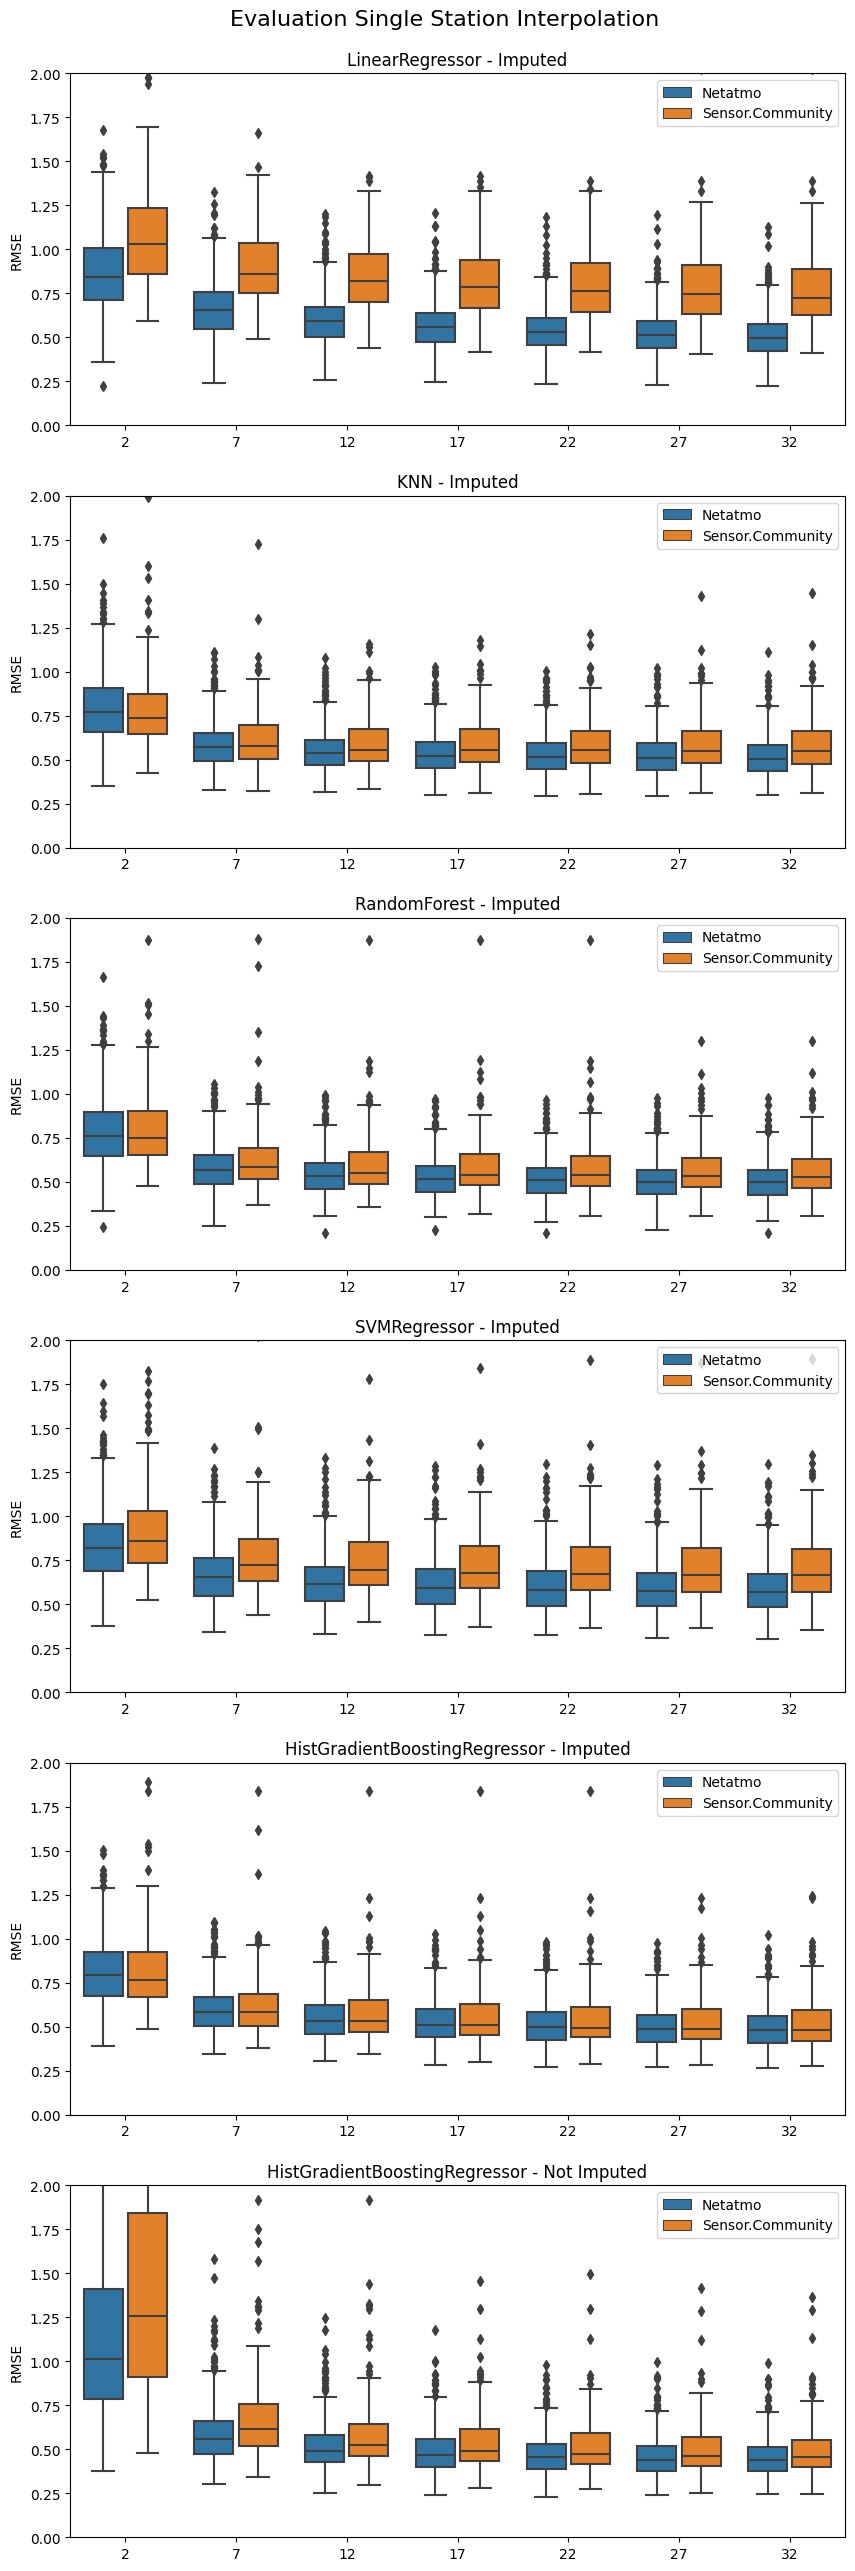

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Scatter plot of evaluation errors by number of neighbours
color_palette = sns.color_palette('tab10')

fig, axs = plt.subplots(6, 1, figsize=(10, 32))
fig.suptitle(F'Evaluation Single Station Interpolation', fontsize=16, y=0.90)

def plot_eval_for_regressor(regressor_type, is_imputed, ax):
    grouped_df = eval_df[(eval_df['regressor_type'] == regressor_type) & (eval_df['is_imputed'] == is_imputed)]

    # Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
    sns.boxplot(data=grouped_df, x='n_neighbours', y='RMSE', hue="provider", ax=ax)

    ax.set_xlabel(None)
    ax.legend(loc='upper right')
    # ax[0].set_ybound()

for entry in [("LinearRegressor", True, 0), ("KNN", True, 1), ("RandomForest", True, 2), ("SVMRegressor", True, 3), ("HistGradientBoostingRegressor", True, 4), ("HistGradientBoostingRegressor", False, 5)]:
    regr_type = entry[0]
    is_imputed = entry[1]
    ax_idx = entry[2]
    ax = axs[ax_idx]

    ax.set_ylim(0, 2)

    if is_imputed:
        ax.set_title(f'{regr_type} - Imputed')
    else:
        ax.set_title(f'{regr_type} - Not Imputed')

    plot_eval_for_regressor(regr_type, is_imputed, ax)

axs[5]

adjust_box_widths(fig, 0.9)
plt.legend(loc='upper right')
plt.show()

# both into one subplot side by side
# legend - Netatmo Hamburg, Sensor.Community Stuttgart (two colors)




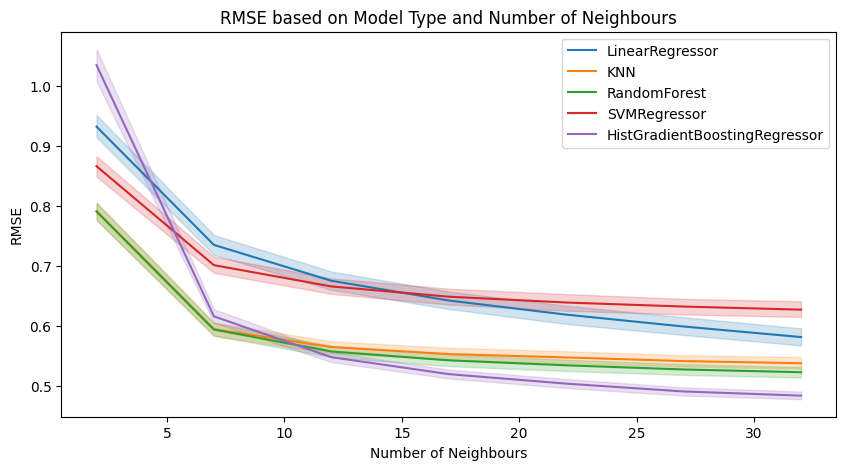

In [14]:
import seaborn as sns

# Define the color palette for the lines
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, ax = plt.subplots(figsize=(10, 5))

grouped_df = eval_df

# Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
sns.lineplot(data=grouped_df, x='n_neighbours', y='RMSE', ax=ax, hue="regressor_type", legend='auto', color=color_palette)

ax.set_title('RMSE based on Model Type and Number of Neighbours')
ax.legend(loc='upper right')
# axs[0].set_title('Mean Absolute Error')
ax.set_xlabel('Number of Neighbours')
# axs[0].set_ylabel('MAE')

plt.show()